In [1]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import seaborn as sns

In [2]:

pca_data = np.loadtxt('pca_data_online_3.txt')

print("Data shape:", pca_data.shape)
print(pca_data[:5])
print(pca_data.shape[0])


Data shape: (1000, 500)
[[ 0.11929579 -0.28282092  0.43783301 ... -0.37684796 -0.26301438
  -0.2979381 ]
 [ 0.10268547 -0.22463877  0.35596211 ... -0.37486502 -0.3253241
  -0.27065528]
 [-0.01847063  0.05269699  0.21304957 ... -0.23204524 -0.11323915
  -0.14600649]
 [ 0.05474361 -0.02590699  0.17636384 ... -0.18858217 -0.20907592
  -0.20743254]
 [ 0.1427989  -0.29856376  0.68930181 ... -0.64518465 -0.58256497
  -0.46317908]]
1000


In [3]:
data_mean = np.mean(pca_data, axis=0)
data_std = np.std(pca_data, axis=0)

pca_data = (pca_data-data_mean) / data_std


In [4]:
# principa component analysis for the given data
def to_PCA(pca_data,n_components):
    # data_mean = np.mean(pca_data, axis=0)
    # mean_centered_data = pca_data-data_mean
    # print(mean_centered_data.shape)
    n_samples = pca_data.shape[0]
    cov_matrix=np.dot(pca_data.T, pca_data) / n_samples 
    print(cov_matrix.shape)
    # using library was allowed in the spec
    eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
    print(eigen_values.shape)
    print(eigen_vectors.shape)
    

    idx = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    
    
    selected_vectors = eigen_vectors[:, :n_components]
    projected_data = np.dot(pca_data, selected_vectors)

    return projected_data


    

(500, 500)
(500,)
(500, 500)
(1000, 2)


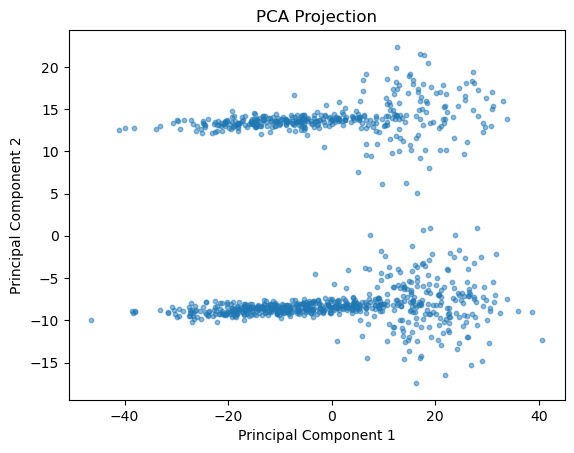

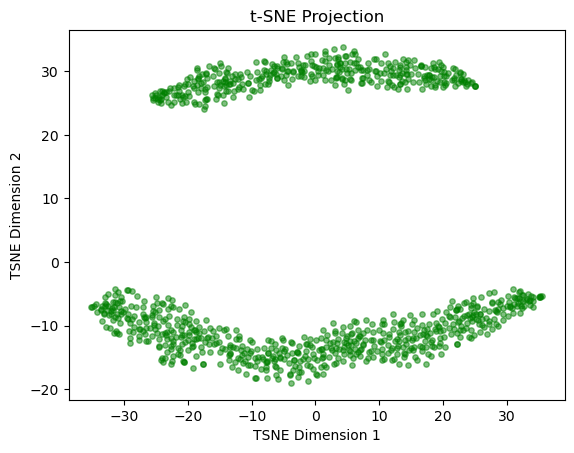

In [5]:
after_pca_data = to_PCA(pca_data,2)
print(after_pca_data.shape)

  # Plot PCA 2D projection
plt.scatter(after_pca_data[:, 0], after_pca_data[:, 1], alpha=0.5,s=10)
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# t-SNE plot
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(pca_data)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5, color='green',s=15)
plt.title("t-SNE Projection")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
plt.show()


d:\New folder\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


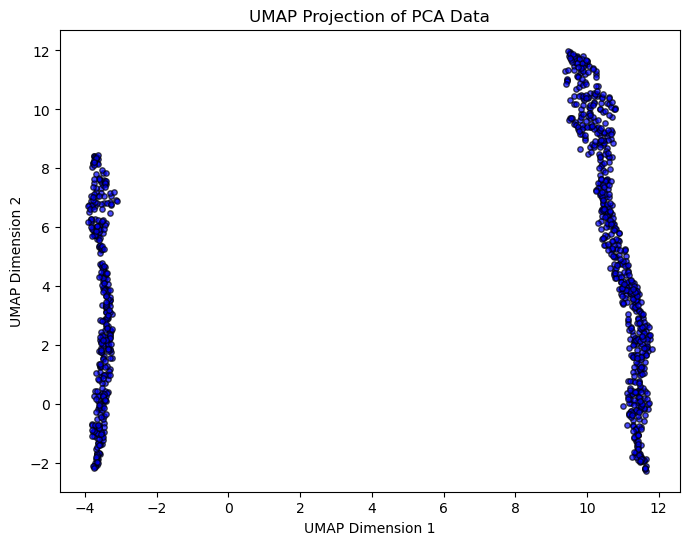

In [6]:
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(pca_data)

# Visualize the UMAP result
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='blue', alpha=0.7, edgecolor='k',s=15)
plt.title("UMAP Projection of PCA Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [7]:

em_data = np.loadtxt('em_data_online_3.txt')

print("Data shape:", em_data.shape)
print(em_data[:5])
print(em_data.shape[0])

Data shape: (10000,)
[0. 4. 4. 5. 5.]
10000


In [8]:
from scipy.stats import poisson

def EM_algo(em_data,n_clusters=2,max_iter=100,tol=1e-6):
    n_samples = len(em_data)
    
    # Initialize guess for lambda and and the proportions of the clusters
    lambdas = np.random.rand(n_clusters) + 1  
    proportions = np.ones(n_clusters) / n_clusters  # 0.5
    responsibilities = np.zeros((n_samples, n_clusters))  
    log_likelihoods = []
   
    for i in range(max_iter):
        # E-step 
        for k in range(n_clusters):
            responsibilities[:, k] = proportions[k] * poisson.pmf(em_data, lambdas[k])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)  # Normalize
        
        # M-step 
        lambdas_new = np.sum(responsibilities * em_data[:, None], axis=0) / np.sum(responsibilities, axis=0)
        proportions_new = np.mean(responsibilities, axis=0)

        log_likelihood = np.sum(np.log(np.sum(responsibilities * poisson.pmf(em_data[:, None], lambdas), axis=1)))
        log_likelihoods.append(log_likelihood)
        
        # convergence check kora lagbe 
        if np.linalg.norm(lambdas - lambdas_new) < tol:
            break
        lambdas, proportions = lambdas_new, proportions_new
    
    return lambdas, proportions,log_likelihoods


In [9]:
lambdas, proportions,log_likelihoods = EM_algo(em_data)
print(f"Estimated Mean and proportion of the cluster(families) without family planning: {lambdas[0]} and {proportions[0]}")
print(f"Estimated Mean and proportion of the cluster(families) with family planning: {lambdas[1]} and {proportions[1]}")


Estimated Mean and proportion of the cluster(families) without family planning: 14.874294073766563 and 0.10193510661934874
Estimated Mean and proportion of the cluster(families) with family planning: 3.0093451682865733 and 0.898064893380687


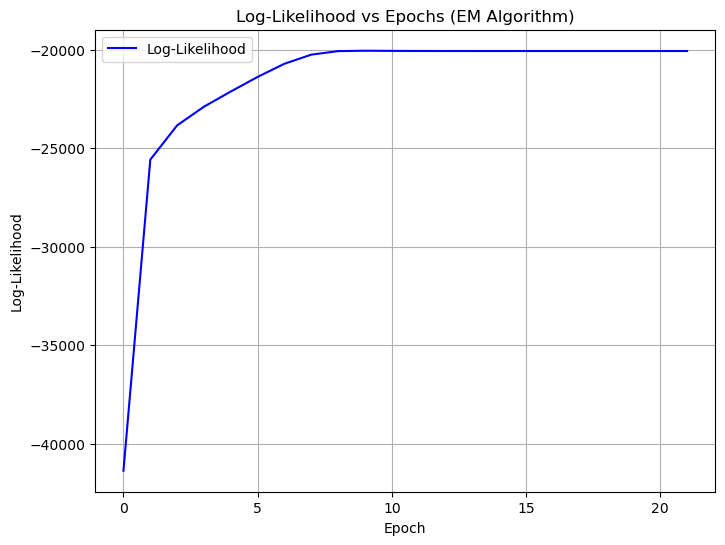

In [10]:
# Plot Log-Likelihood vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(log_likelihoods, label='Log-Likelihood', color='b')
plt.title("Log-Likelihood vs Epochs (EM Algorithm)")
plt.xlabel("Epoch")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()


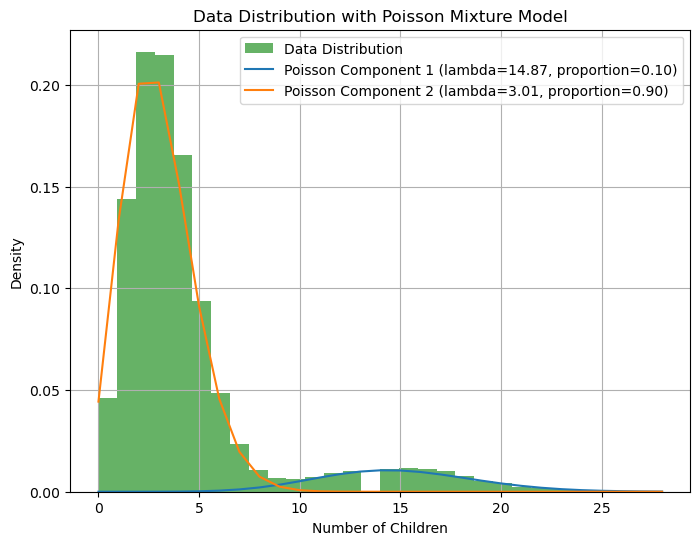

In [11]:
# Plot the original data distribution (Histogram)
plt.figure(figsize=(8, 6))
plt.hist(em_data, bins=30, density=True, alpha=0.6, color='g', label='Data Distribution')

# Plot the estimated Poisson distributions from the EM algorithm
x = np.arange(0, max(em_data) + 1)
for k in range(len(lambdas)):
    poisson_dist = poisson.pmf(x, lambdas[k])
    plt.plot(x, poisson_dist * proportions[k], label=f'Poisson Component {k+1} (lambda={lambdas[k]:.2f}, proportion={proportions[k]:.2f})')

plt.title("Data Distribution with Poisson Mixture Model")
plt.xlabel("Number of Children")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()
